In [1]:
%load_ext watermark
%watermark -a 'cs224' -u -d -v -p numpy,scipy,pandas,matplotlib,seaborn

cs224 
last updated: 2020-05-02 

CPython 3.6.10
IPython 7.13.0

numpy 1.18.1
scipy 1.4.1
pandas 1.0.2
matplotlib 3.1.3
seaborn 0.10.0


In [2]:
import numpy as np, scipy, scipy.stats as stats, scipy.special, scipy.misc, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import matplotlib as mpl
import sympy

sns.set()

from IPython.display import display, HTML

display(HTML("<style>.container { width:70% !important; }</style>"))

import os,sys
sys.path.append(os.path.dirname(os.path.realpath('.')))

In [3]:
%load_ext autoreload
%autoreload 1
%aimport covid19

## Infection Dynamics: Curve Fitting

[Markus Noga](https://www.linkedin.com/in/mlnoga/)'s (SAP: AI and cloud thought leader) [covid19-analysis](https://mlnoga.github.io/covid19-analysis/)

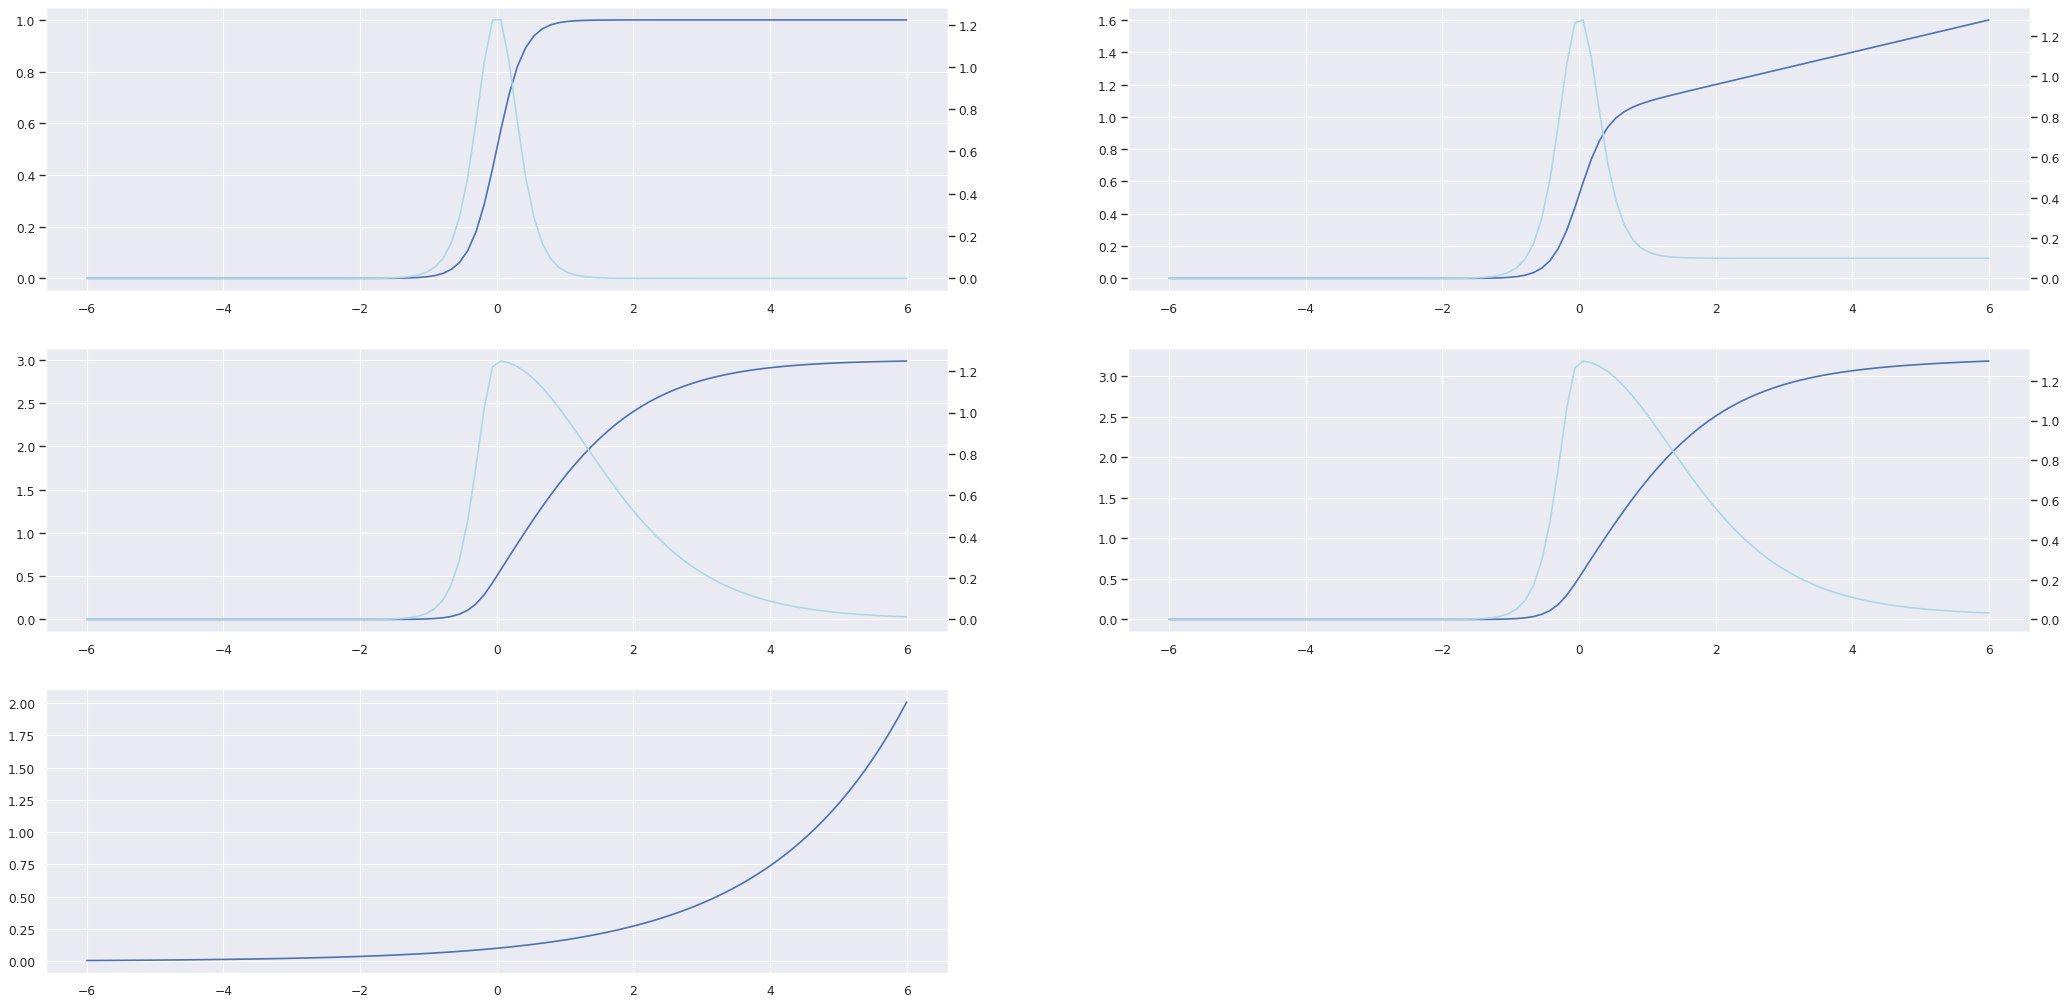

In [4]:
x = np.linspace(-6.0,6.0,100)
fig = plt.figure(figsize=(32,16), dpi=80, facecolor='w', edgecolor='k')

ax = plt.subplot(3,2,1)
ax.plot(x, covid19.fitSig(x, 1.0, 5.0, 0.0))
ax2 = ax.twinx()
ax2.plot(x, covid19.fitSigDerivative(x, 1.0, 5.0, 0.0), c='lightblue')
ax2.grid(None)

ax = plt.subplot(3,2,2)
ax.plot(x, covid19.fitSigExt(x, 1.0, 5.0, 0.0, 0.02))
ax2 = ax.twinx()
ax2.plot(x, covid19.fitSigExtDerivative(x, 1.0, 5.0, 0.0, 0.02), c='lightblue')
ax2.grid(None)

ax = plt.subplot(3,2,3)
ax.plot(x, covid19.fitSigAsymmetric(x, 1.0, 5.0, 1.0, 0.0))
ax2 = ax.twinx()
ax2.plot(x, covid19.fitSigAsymmetricDerivative(x, 1.0, 5.0, 1.0, 0.0), c='lightblue')
ax2.grid(None)

ax = plt.subplot(3,2,4)
ax.plot(x, covid19.fitSigExtAsymmetric(x, 1.0, 5.0, 1.0, 0.0, 0.02))
ax2 = ax.twinx()
ax2.plot(x, covid19.fitSigExtAsymmetricDerivative(x, 1.0, 5.0, 1.0, 0.0, 0.02), c='lightblue')
ax2.grid(None)

ax = plt.subplot(3,2,5)
ax.plot(x, covid19.fitExp(x, 0.1, 0.5))

Example of how the top left graph was created via a sigmoid function together with its derivative:

In [5]:
st, sa, sb, sc, sn = sympy.symbols('t a b c n')
fnsig = sa / (1 + sympy.exp(-sb * st - sc))
fnsig

a/(exp(-b*t - c) + 1)

In [6]:
fnsigderivative = sympy.diff(fnsig, st)
fnsigderivative

a*b*exp(-b*t - c)/(exp(-b*t - c) + 1)**2

In [7]:
fnsigext = sa / (1 + sympy.exp(-sb * st - sc)) + sn*sympy.log(1+sympy.exp(sb*st + sc))
fnsigext

a/(exp(-b*t - c) + 1) + n*log(exp(b*t + c) + 1)

Workhorse:

* [`scipy.optimize.curve_fit`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)
* [`scipy.optimize.minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)

Beware: it is not a [*convex*](https://en.wikipedia.org/wiki/Convex_optimization) problem and you have to play with initial conditions either via [grid search](https://scikit-learn.org/stable/modules/grid_search.html) are "good guesses".

In [8]:
df = covid19.get_rki_df()
df = df[df.index < pd.to_datetime('2020-05-02')]
cbr_germany = covid19.CasesByRegion('Germany', df=df)
cbr_germany.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-04-27,158872,128930,5842,909,0,106
2020-04-28,159732,128930,6054,860,0,212
2020-04-29,160584,128930,6256,852,0,202
2020-04-30,161370,128930,6400,786,0,144
2020-05-01,161653,128930,6736,283,0,336


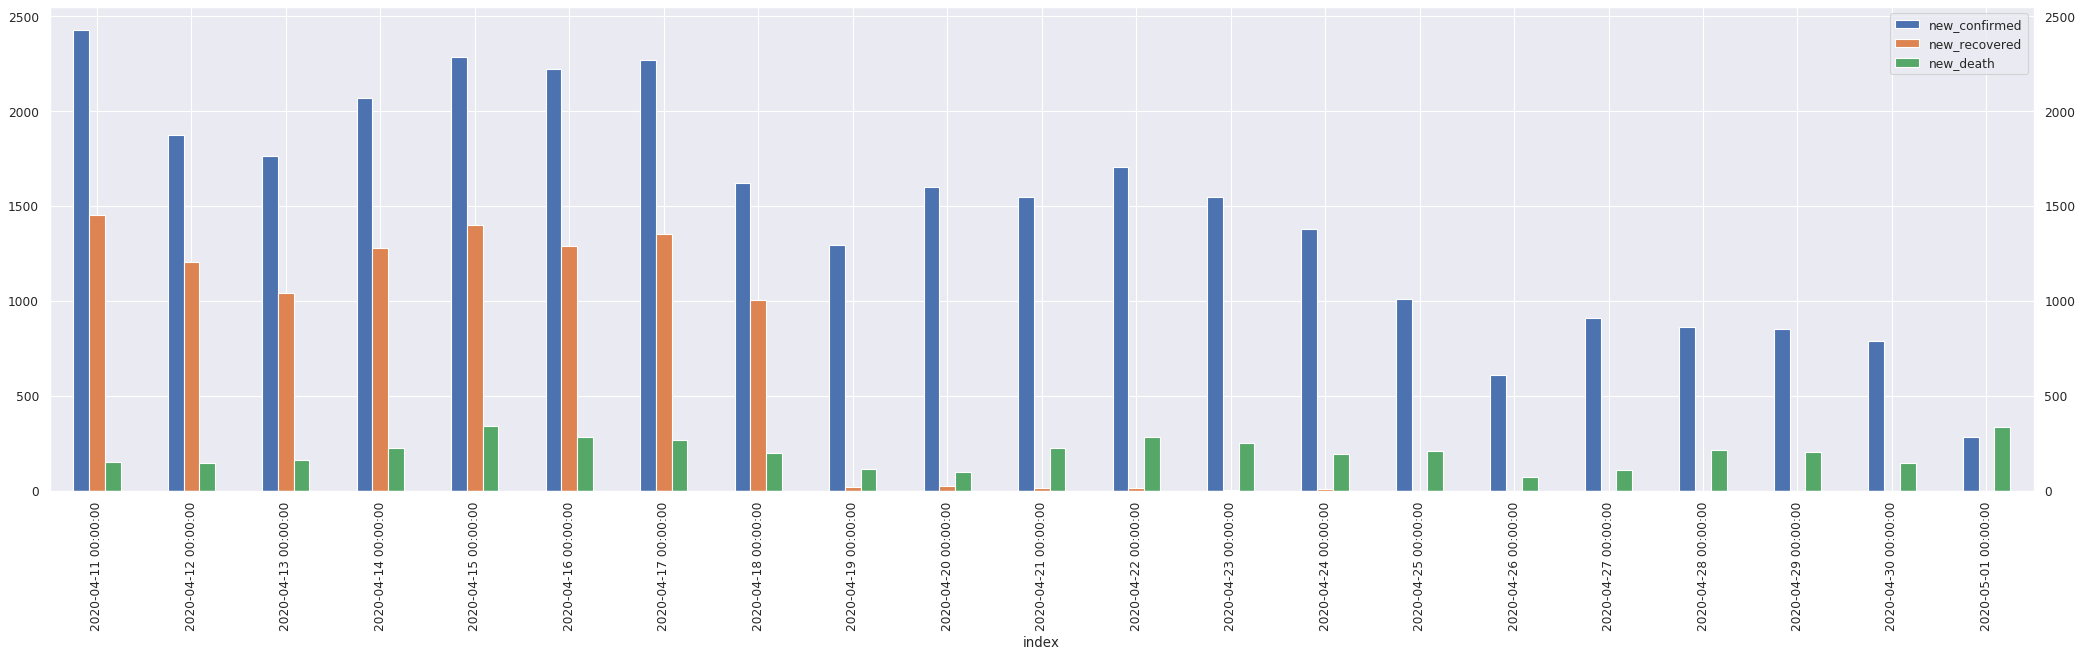

In [9]:
cbr_germany.plot_daily_stats()

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None
 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning:Covariance of the parameters could not be estimated


sigmoid+asymmetric: seor: 508.4535760730587, max asymptotic: 176278.2001608488; growth-rate: 0.006, date:2020-06-06 00:00:00, projected value: 91.44740647616838


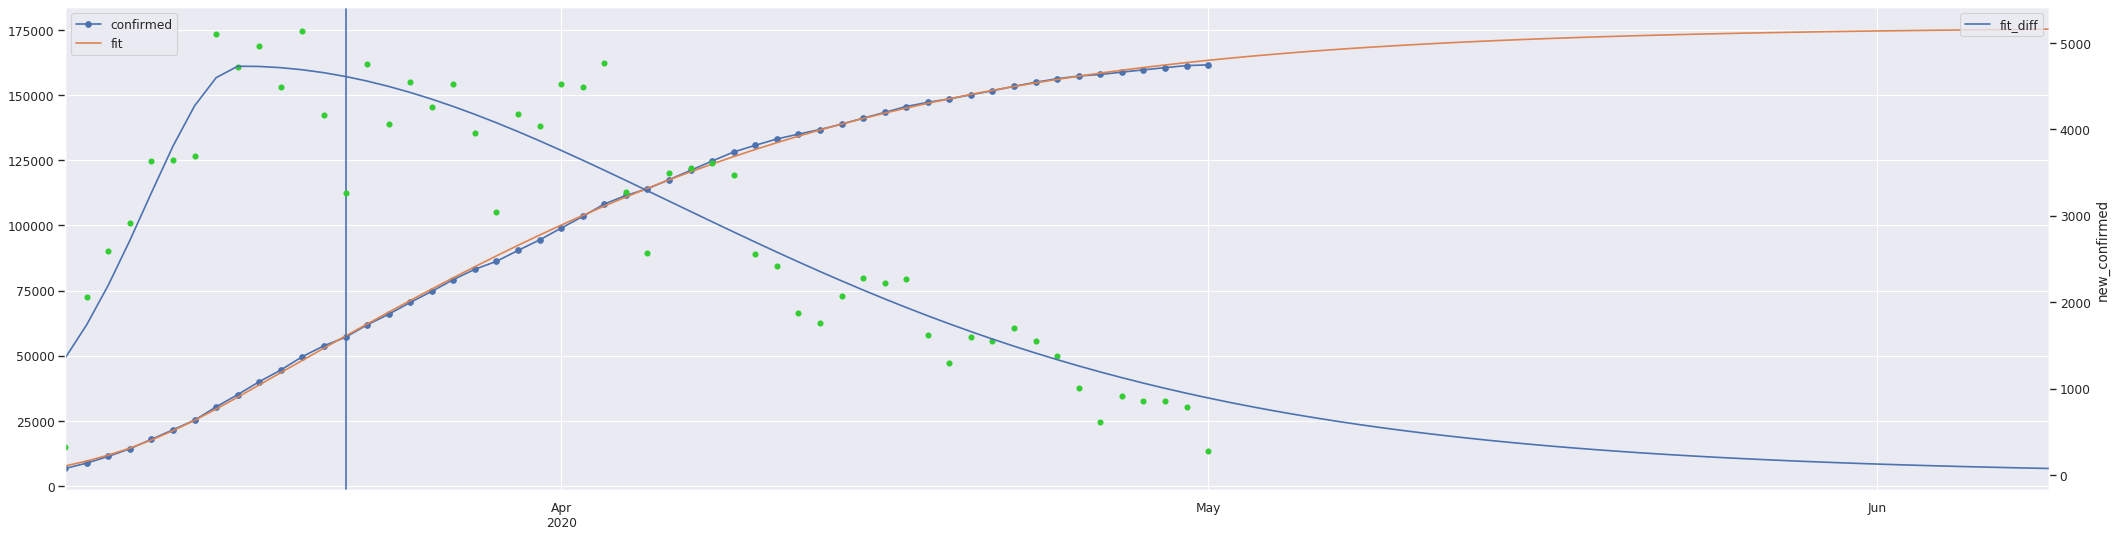

In [10]:
cbr_germany.fit(first_date=pd.to_datetime('2020-03-09'))
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_germany.plot_with_fits(ax=ax, restriction_start_date=pd.to_datetime('2020-03-22'))